In [1]:
import pypsa

import pandas as pd
import matplotlib.pyplot as plt

ERROR 1: PROJ: proj_create_from_database: Open of /fp/homes01/u01/ec-koenvg/.conda/envs/my_base/envs/eu-hydrogen/share/proj failed


# Demand

In [2]:
n2025 = pypsa.Network(
    "networks/base_s_60_lc1.5__Ca-Ia-Ea_2025.nc"
)
n2050 = pypsa.Network(
    "networks/base_s_60_lc1.5__Ca-Ia-Ea_2050.nc"
)

eb25 = n2025.statistics.energy_balance()
eb50 = n2050.statistics.energy_balance()

INFO:pypsa.io:Imported network base_s_60_lc1.5__Ca-Ia-Ea_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_60_lc1.5__Ca-Ia-Ea_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
# Ammonia demand
nh3_tonnes = -eb25.loc[("Load", "NH3")].iloc[0] / 1e6

print("Ammonia demand [Mt/a]:", round(nh3_tonnes / 5.18, 1))
print("Ammonia demand [TWh]:", round(nh3_tonnes, 1))

Ammonia demand [Mt/a]: 16.5
Ammonia demand [TWh]: 85.4


In [4]:
# Methanol demand
meoh = (
    -eb25.xs("industry methanol", level="bus_carrier")
    .xs("Load", level="component")
    .squeeze()
    / 1e6
)

print("Methanol demand [TWh/a]:", round(meoh, 1))

Methanol demand [TWh/a]: 8.7


In [5]:
# Oil demand in industry
eb25.xs("oil", level="bus_carrier")
oil_ind_25 = -eb25.loc[("Link", "naphtha for industry", "oil")] / 1e6
oil_ind_50 = -eb50.loc[("Link", "naphtha for industry", "oil")] / 1e6

print(
    f"Oil demand for industry [Mt/a]: {round(oil_ind_25, 1)} (2025), {round(oil_ind_50, 1)} (2050)"
)

Oil demand for industry [Mt/a]: 918.7 (2025), 276.8 (2050)


In [6]:
# Agriculture machinery oil demand
oil_agg = (
    -eb50.xs("oil", level="bus_carrier")
    .xs("agriculture machinery oil", level="carrier")
    .squeeze()
    / 1e6
)

print(f"Oil demand for agriculture machinery [TWh/a]: {round(oil_agg, 1)}")

Oil demand for agriculture machinery [TWh/a]: 102.8


# Supply

In [7]:
# Biomass availability
for i in ["a", "b", "c"]:
    biomass = pd.read_csv(f"../resources/Y1987_B{i}/biomass_potentials_s_45_2050.csv")
    print(f"Solid biomass in setting {i}: {(biomass['solid biomass'].sum() / 1e6).round(-1)} TPWh")
    print(f"Biogas in setting {i}:        {(biomass['biogas'].sum() / 1e6).round(-1)} TWh")

Solid biomass in setting a: 340.0 TPWh
Biogas in setting a:        180.0 TWh
Solid biomass in setting b: 1010.0 TPWh
Biogas in setting b:        360.0 TWh
Solid biomass in setting c: 2630.0 TPWh
Biogas in setting c:        530.0 TWh


In [8]:
n2025.generators.p_nom_max

Generator
AL0 0 curtailment                                     1.000000e+06
AL0 0 ror                                             4.820020e+01
AL0 0 urban central heat vent                                  inf
AT0 0 curtailment                                     1.000000e+06
AT0 0 gas                                             1.785957e+03
                                                          ...     
SK0 0 solar-2015                                               inf
SK0 0 solar-2020                                               inf
SK0 0 solar-2025                                      9.858302e+04
SK0 0 urban central solar thermal collector-2025               inf
SK0 0 urban decentral solar thermal collector-2025             inf
Name: p_nom_max, Length: 1117, dtype: float64

In [9]:
# Total installable capacity
gen_ex = n2025.generators.loc[n2025.generators.p_nom_extendable]
print((gen_ex.groupby("carrier").p_nom_max.sum()[["solar", "onwind"]] / 1e6).round(1))

carrier
solar     10.7
onwind     8.6
Name: p_nom_max, dtype: float64


# Costs

In [10]:
years = [2025, 2030, 2035, 2040, 2045, 2050]

import_carriers = {
    "H2": "shipping-lh2",
    "ammonia": "shipping-lnh3",
    "methanol": "shipping-meoh",
    "oil": "shipping-ftfuel",
    "gas": "shipping-lch4",
}

pretty_carrier_names = {
    "H2": "Hydrogen",
    "ammonia": "Ammonia",
    "methanol": "Methanol",
    "oil": "Oil",
    "gas": "Gas",
}

costs = {
    y: pd.read_csv(f"../resources/Y1987_Bb/costs_{y}.csv", index_col=[0, 1])
    for y in years
}

# Create table with years as columns, carriers as rows and fuel costs as values
import_costs = pd.DataFrame(index=import_carriers.keys(), columns=years)
for y in years:
    for carrier, name in import_carriers.items():
        import_costs.at[carrier, y] = costs[y].at[(name, "fuel"), "value"]

import_costs.index = import_costs.index.map(pretty_carrier_names)
# Round values to 1 decimal
import_costs = import_costs.astype(float).round(1)

import_costs.index.name = "Carrier"

display(import_costs)
import_costs.to_csv("figures/import_costs.csv")

,2025,2030,2035,2040,2045,2050
Carrier,,,,,,
Hydrogen,122.9,122.9,112.0,101.2,92.7,84.1
Ammonia,120.1,120.1,110.3,100.6,94.5,88.4
Methanol,165.6,165.6,151.9,138.2,128.5,118.7
Oil,234.2,234.2,214.0,193.9,178.6,163.4
Gas,128.4,128.4,118.2,108.1,102.2,96.2


# Conversion technologies

In [11]:
n = n2050

for carrier in ["oil", "gas", "methanol", "NH3", "H2"]:
    print(
        f"Production of {carrier}: {n.links.loc[n.links.bus1.map(n.buses.carrier) == carrier].carrier.unique()}"
    )

Production of oil: ['oil green import' 'oil refining' 'Fischer-Tropsch' 'biomass to liquid']
Production of gas: ['biogas to gas' 'gas green import' 'gas pipeline' 'Sabatier'
 'gas pipeline new']
Production of methanol: ['methanol green import' 'methanolisation' 'biomass-to-methanol CC'
 'biomass-to-methanol']
Production of NH3: ['ammonia green import' 'Haber-Bosch']
Production of H2: ['H2 Electrolysis' 'H2 green import' 'solid biomass to hydrogen' 'SMR CC'
 'SMR' 'ammonia cracker' 'H2 pipeline']


# Storage technologies

In [12]:
n.stores.carrier.groupby(n.stores.bus.map(n.buses.carrier)).unique()

bus
EV battery                                      [EV battery]
H2                                                [H2 Store]
NH3                                          [ammonia store]
battery                                            [battery]
biogas                                              [biogas]
co2                                                    [co2]
co2 sequestered                            [co2 sequestered]
co2 stored                                      [co2 stored]
coal                                                  [coal]
gas                                                    [gas]
lignite                                            [lignite]
methanol                                          [methanol]
oil                                                    [oil]
rural water tanks                        [rural water tanks]
solid biomass                                [solid biomass]
uranium                                            [uranium]
urban central water 

In [13]:
print("Dispatch capacity:")
display(n.storage_units.groupby("carrier").p_nom.sum() / 1e3) # GW

print("Max hours:")
display(n.storage_units.groupby("carrier").max_hours.mean())

print("Storage capacity:")
display(
    (n.storage_units.p_nom * n.storage_units.max_hours)
    .groupby(n.storage_units.carrier)
    .sum()
    / 1e6 # TWh
)

Dispatch capacity:


carrier
PHS       56.877539
hydro    103.147440
Name: p_nom, dtype: float64

Max hours:


carrier
PHS       159.177158
hydro    7614.689160
Name: max_hours, dtype: float64

Storage capacity:


carrier
PHS        8.660856
hydro    152.405015
dtype: float64

In [14]:
# BEV storage
bev_battery = n.stores.loc[n.stores.carrier == "EV battery"].index
print("EV battery capacity:", n.stores.loc[bev_battery].e_nom.sum() / 1e6) # TWh

# BEV v2g capacity
print("EV v2g dispatch capacity:", n.links.loc[n.links.carrier == "V2G", "p_nom"].sum() / 1e3) # GW

EV battery capacity: 5.217019241210937
EV v2g dispatch capacity: 2295.4884658203123


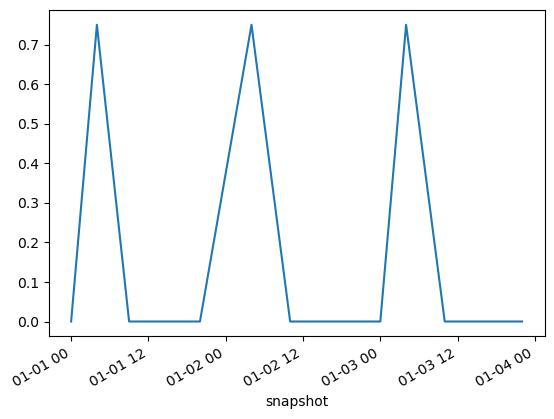

<Axes: xlabel='snapshot'>

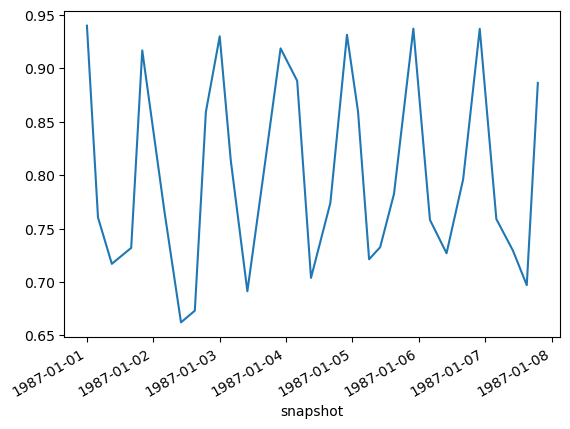

In [15]:
# EV storage requirements and charging availability respectively

n.stores_t.e_min_pu[bev_battery].mean(axis=1).loc[
    "1987-01-01 00:00":"1987-01-03 23:00"
].plot()
plt.show()

n.links_t.p_max_pu[n.links.loc[n.links.carrier == "BEV charger"].index].mean(
    axis=1
).loc["1987-01-01 00:00":"1987-01-07 23:00"].plot()

In [16]:
# Salt cavern hydrogen storage
salt_caverns = n.stores.loc[(n.stores.carrier == "H2 Store") & (n.stores.index.str.endswith("-2050"))]

print("Salt cavern locations:" , salt_caverns.bus.unique())

print("Max potential underground hydrogen storage:", salt_caverns.e_nom_max.sum() / 1e6) # TWh

Salt cavern locations: ['DE0 2 H2' 'DE0 3 H2' 'DE0 4 H2' 'DK0 0 H2' 'DK1 0 H2' 'ES0 1 H2'
 'ES0 2 H2' 'GB3 0 H2' 'GB3 3 H2' 'GB4 0 H2' 'GR0 0 H2' 'NL0 0 H2'
 'PL0 1 H2' 'PT0 0 H2']
Max potential underground hydrogen storage: 2725.7192803964845


In [17]:
# Gas storage
gas_storage = n2025.stores.loc[n2025.stores.carrier == "gas"]
print("Gas storage capacity:", gas_storage.e_nom_opt.sum() / 1e6) # TWh

Gas storage capacity: 1327.7402002265626


# Emissions

In [18]:
print("Process emissions in 2025:", n2025.statistics.energy_balance().loc[("Load", "process emissions")].squeeze() / 1e6)
print("Process emissions in 2050:", n2050.statistics.energy_balance().loc[("Load", "process emissions")].squeeze() / 1e6)

Process emissions in 2025: 189.81000328125
Process emissions in 2050: 123.0600009375


# Value of hydrogen sector

In [19]:
stat_names = [
    "h2prod",
    "imports",
    "system_cost",
    "obj_bound_dual",
    "h2price",
    "h2value",
    "co2seq",
    "dac",
    "captured_co2",
    "elec_cap",
    "elec_cf",
    "total_onwind",
    "total_offwind",
    "total_solar",
    "total_nuclear",
    "total_h2_storage",
]

fn = f"cache_results.csv"
cols = pd.read_csv(fn).columns
df = pd.read_csv(fn, index_col=list(range(len(cols) - len(stat_names))))

# Convert "year" index level values from int to str
df.index = df.index.set_levels(df.index.levels[1].astype(str), level=1)

Fraction of system cost covered by hydrogen value:


count    72.0
mean      3.8
std       3.5
min       0.0
25%       0.4
50%       3.1
75%       6.2
max      12.4
dtype: float64

Fraction of system cost covered by hydrogen value for values > 1%:


count    51.0
mean      5.4
std       3.1
min       1.1
25%       2.8
50%       4.8
75%       7.9
max      12.4
dtype: float64

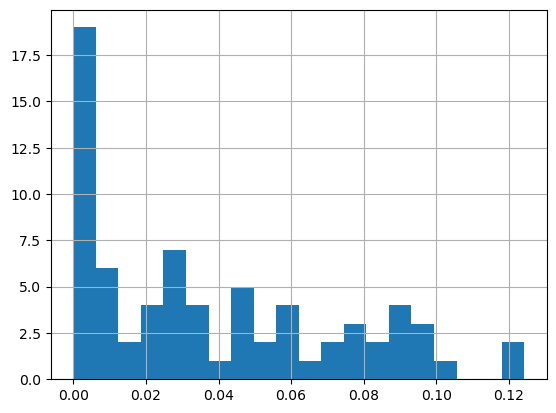

In [20]:
frac_sys_cost = (df.h2value / df.system_cost).xs("opt", level="sense").xs(2050, level="horizon")

frac_sys_cost.hist(bins=20)

print("Fraction of system cost covered by hydrogen value:")
display((frac_sys_cost * 100).describe().round(1))

print("Fraction of system cost covered by hydrogen value for values > 1%:")
display((frac_sys_cost.loc[frac_sys_cost > 0.01] * 100).describe().round(1))